In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# not used
#https://www.kaggle.com/JobsPikrHQ/usa-based-job-data-set-from-300-companies
# file = 'C:/users/hvu7470/Downloads/US-based jobs.csv'

# download job postings

In [ ]:
#from https://www.kaggle.com/madhab/jobposts/version/1
file = 'data/data job posts.csv'
df = pd.read_csv(file)
df.shape

In [ ]:
cols = ['Title']
# , 'JobDescription']
# , 'JobRequirment','RequiredQual']
df[cols].head()
df.columns

In [ ]:
# def profileDs(df):    
#     pd.options.display.float_format = '{:.0f}'.format

#     df2 = pd.DataFrame()
#     for c in df.columns:
#         d = dict()
#         d['col'] = c
#         d['dtype'] = str(type(df.iloc[0][c])).replace("<class '",'').replace('numpy.','').replace("'>",'')
#         d['nulls'] = df[df[c].isna()].shape[0]
#         d['zeros'] = df[df[c].astype('str')=='0'].shape[0]
#         d['empty']=df[df[c].astype('str').replace(" ",'').apply(lambda x: len(x)==0)].shape[0]
#         d['min'] = df[~df[c].isna()][c].min()
#         d['max'] = df[~df[c].isna()][c].max()
#         d['unique'] = df[c].nunique()

#         lst = [len(x) for x in df[c].astype('str').unique()]
#         d['minLength'] = min(lst)
#         d['maxLength'] = max(lst)

#         d['count'] = df[c].shape[0]

#         df1 = pd.DataFrame.from_dict(d,orient='index') 
#         df2 = pd.concat([df2,df1],axis=1)
#     return df2.T.reset_index().drop('index',axis=1)

# profileDs(df[cols].copy(deep=True))

# create features from text

In [399]:
import re
import nltk

# nltk.download('punkt')
from nltk.tokenize import word_tokenize as wt 
# nltk.download('stopwords')
from nltk.corpus import stopwords

# from nltk.stem.porter import PorterStemmer
# stemmer = PorterStemmer()

data = []
# for i in range(df.shape[0]):
#     sms = "".join([str(df.iloc[i][c]) for c in cols])
# for r in zip(df.Title, df.JobDescription):
#     sms = "".join(str(r[0])+' '+str(r[1])).lower()
for r in zip(df.Title):
    sms = "".join(str(r[0])).lower()
    sms = re.sub('[^A-Za-z]', ' ', sms)  # alpha characters only
    tokenized_sms = wt(sms)
#     sms_processed = []
#     for word in tokenized_sms:
#         if word not in set(stopwords.words('english')):
#             sms_processed.append(word)
    sms_text = " ".join(tokenized_sms)
    data.append(sms_text)

In [400]:
wordCount = pd.DataFrame.from_dict(dict(FreqDist(wt(pd.Series(data).str.cat(sep='\n')))), orient='index')
wordCount.columns=['WordCount']
wordCount = wordCount.sort_values(by='WordCount',ascending=False)
wordCount['stopword'] = [1 if r.Index in stopwords.words('english') else 0 for r in wordCount.itertuples()]
wordCount.head()

,WordCount,stopword
manager,2590,0
specialist,2045,0
developer,1913,0
engineer,1607,0
senior,1492,0


In [401]:
# top words i might use as features
cond = (wordCount.stopword!=1) & (wordCount.WordCount>50)
wordCount[cond].index.str.cat(sep='|')

'manager|specialist|developer|engineer|senior|assistant|software|sales|accountant|department|officer|project|head|marketing|development|chief|director|coordinator|c|administrator|administrative|representative|web|consultant|financial|expert|designer|analyst|net|program|java|medical|division|service|technical|qa|business|language|credit|management|system|branch|unit|executive|finance|support|translator|english|lawyer|office|legal|customer|junior|team|php|hr|quality|receptionist|programmer|database|intern|internal|monitoring|leader|secretary|national|training|procurement|information|network|corporate|operations|auditor|deputy|supervisor|programme|agent|operator|loan|center|cashier|public|advisor|design|security|assurance|courses|human|services|product|architect|relations|asp|graphic|control|accounting|pr|commercial|logistics|local|reporting|systems|risk|interpreter|market|driver|international|research|audit|leading|mobile|armenia|general|social|application|administration|resources|associ

In [408]:
wordsToExclude = stopwords.words('english') + ['nan','head','armenia','qualified','incumbent','highly','well'\
,'work','responsible','senior','office','seeking','responsible','llc','looking']

# creating the feature matrix 
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# matrix = CountVectorizer(max_features=50)
matrix = TfidfVectorizer(max_features=50,stop_words=wordsToExclude)
X = matrix.fit_transform(data).toarray()
X.shape

# feature words
pd.DataFrame(X,columns=matrix.get_feature_names()).sum().sort_values(ascending=False)

(19001, 50)

manager           1904.934473
specialist        1490.598495
developer         1347.116213
engineer          1207.603226
assistant          873.242127
software           748.314434
accountant         660.836775
sales              626.540727
officer            548.703864
department         527.722057
project            458.744762
marketing          456.392193
director           411.079358
coordinator        401.980280
administrator      397.506783
chief              387.699207
development        387.309908
administrative     340.014769
expert             339.538305
designer           334.525033
consultant         328.951309
web                315.812189
representative     301.260334
analyst            294.133056
financial          281.827606
net                274.429710
program            268.035573
java               263.440600
medical            248.341337
division           247.611393
qa                 234.940794
technical          231.451045
service            230.679453
business  

# use kmeans to cluster job postings

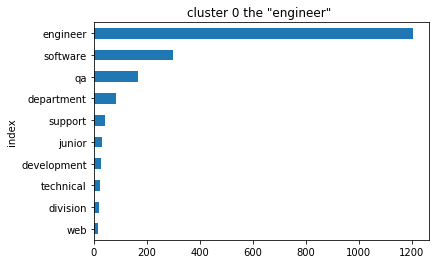

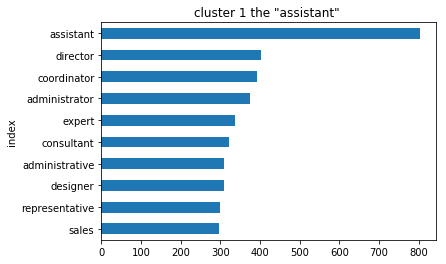

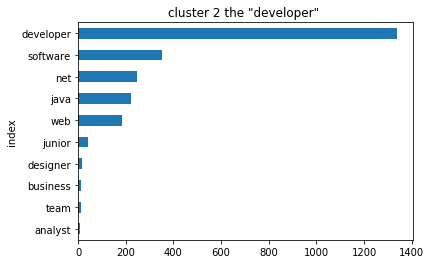

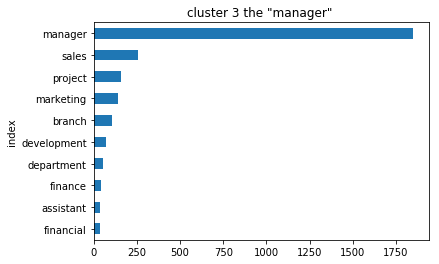

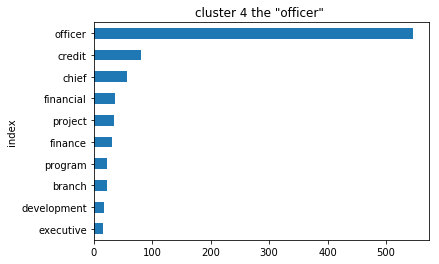

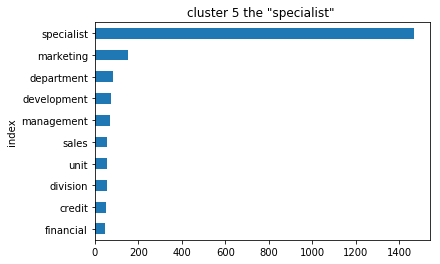

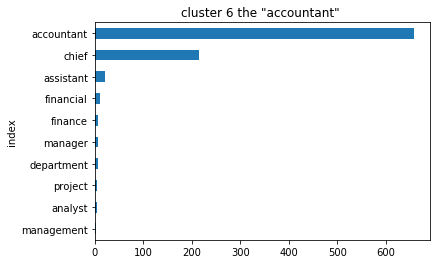

In [509]:
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=7, random_state=0)
y = clf.fit_predict(X)
df['cluster'] = y

# attempt to explain each cluster
# name each cluster using its top word found
clusterNames = []
for c in np.unique(y):
    topStrings = pd.DataFrame(X[df[df.cluster==c].index],columns=matrix.get_feature_names()).sum().sort_values(ascending=False) 
    s = topStrings.index[0]
    ax = topStrings.reset_index().head(10).sort_values(by=0,ascending=True).plot(kind='barh',y=0,x='index'\
    ,title='cluster {} the "{}" '.format(c,s),legend=False)
    clusterNames.append((c,s))
#     'cluster {}: {}'.format(c, topStrings.index[:20].to_list())
#     print(df[df.cluster==c].head(20).Title.to_list())

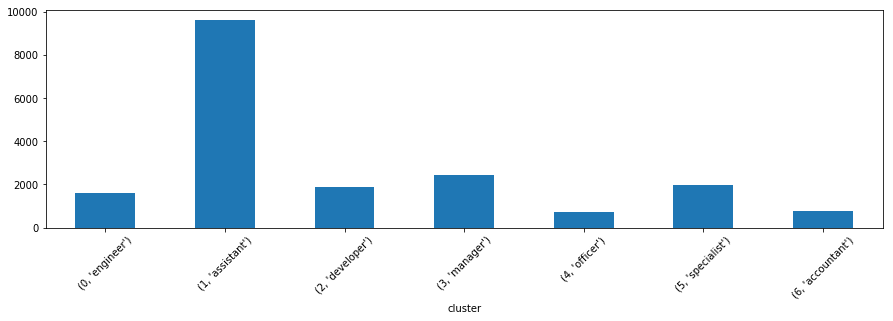

In [510]:
ax = df.groupby('cluster').size().plot(kind='bar',figsize=(15,4))
_ = plt.xticks(rotation=45)
_ = ax.axes.set_xticklabels(clusterNames)

In [511]:
print('top titles are')
df.groupby("Title").size().sort_values(ascending=False)[:5]

df[df.Title.fillna('').str.lower().str.contains('accountant')][cols + ['cluster']].head(5)
# df[df.Title == 'Accountant'][cols + ['cluster']].head(5)


top titles are


Title
Accountant                  328
Chief Accountant            219
Medical Representative      216
Sales Manager               166
Administrative Assistant    155
dtype: int64

,Title,cluster
6,Chief Accountant/ Finance Assistant,6
29,Chief Accountant,6
53,Accountant,6
74,Accountant,6
120,Accountant/ Financial Officer,4


# explain cluster chosen for some samples within the data
use lime text explainer

In [512]:
# can't compute probabilities off kmeans.  use a supervised approach to generate probabilities
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

for clf in [
    MultinomialNB(alpha=.01)
#     ,RandomForestClassifier(n_estimators=10)
]:
    _ = clf.fit(X_train,y_train)
    print('{}\n train score = {:.3f}    test score = {:.3f}\n'.format(
        clf
        ,clf.score(X_train,y_train)
        ,clf.score(X_test,y_test)
    ))
    

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
 train score = 0.977    test score = 0.973



In [513]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(matrix,clf)

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=np.unique(y))
exp = explainer.explain_instance(data[i],c.predict_proba,num_features=1)
# ,top_labels=1)
# print(exp.available_labels())
# exp.show_in_notebook(text=df.Title.iloc[i],labels=(1,))

for i in range(10):
    exp = explainer.explain_instance(data[i],c.predict_proba,num_features=3)
    '{}. Cluster for {} is {}'.format(i,data[i],clusterNames[y[i]])
#     print ('Explanation for class %s' % data[i])
    print ('\n'.join(map(str, exp.as_list())))
    print ()

"0. Cluster for chief financial officer is (4, 'officer')"

('officer', -0.4190067788229789)
('chief', -0.07079471749567959)
('financial', 0.03404587476589352)



"1. Cluster for full time community connections intern paid internship is (1, 'assistant')"

('full', 0.0)
('time', 0.0)
('community', 0.0)



"2. Cluster for country coordinator is (1, 'assistant')"

('coordinator', 0.3462776919397144)
('country', -0.12157244585187034)



"3. Cluster for bcc specialist is (5, 'specialist')"

('specialist', -0.3654413596427356)
('bcc', 0.1285300363744355)



"4. Cluster for software developer is (2, 'developer')"

('developer', -0.17307467094516393)
('software', -0.05282089037936951)



"5. Cluster for saleswoman is (1, 'assistant')"

('saleswoman', 0.0)



"6. Cluster for chief accountant finance assistant is (6, 'accountant')"

('accountant', -0.5940678533340434)
('assistant', 0.11985295783604667)
('chief', -0.11251959807735855)



"7. Cluster for non paid part or full time programmatic intern is (1, 'assistant')"

('non', 0.0)
('paid', 0.0)
('part', 0.0)



"8. Cluster for assistant to managing director is (1, 'assistant')"

('director', 0.19126895098249286)
('assistant', 0.14622123405153223)
('to', 0.025016874213424512)



"9. Cluster for program assistant inl fsn fp is (1, 'assistant')"

('assistant', 0.22717124134348374)
('program', 0.10811739050179554)
('inl', 0.012735243032912546)



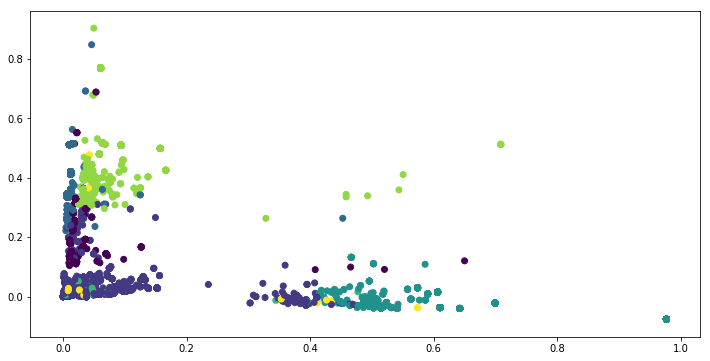

In [544]:
# from sklearn import manifold
from sklearn import decomposition

numPoints = 1000

# dimRed = decomposition.PCA(n_components=2)
dimRed = decomposition.TruncatedSVD(n_components=2)
# dimRed = manifold.TSNE()
Xt = dimRed.fit_transform(X_train)


import matplotlib.cm as cm
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
# myCm = cm.rainbow(np.linspace(0, 1, len(np.linspace(0, 1,len(y_train[:numPoints])))))
fig, ax = plt.subplots()
ax.scatter(x=Xt[:,0],y=Xt[:,1],c=y_train)
# ,label=[clusterNames[i][1] for i in y_train[:numPoints]] )
# ax.legend()
# ax.grid(True)
# plt.show()